# Creating the Initial Conditions

These initial conditions are shown for Jonathan's Earth Current Global model.

First, import packages to re-create and visualize the model fields here:


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from tqdm import tqdm

from eccoseas.downscale import hFac, horizontal
from eccoseas.ecco import io

Next, define the directory locations of the project root, data, and input.

In [2]:
PROJ_ROOT = Path("..").resolve()
DATA_DIR = PROJ_ROOT / "data"
INPUT_DIR = PROJ_ROOT / "input"

## Constructing the Initial Conditions

For my model, I will use a model state from the ECCO Version 5 state estimate. I will prepare the initial condition fields in 7 steps:

1. download 5 fields and 4 grid files generated by the ECCO model in 2009
2. read the ECCO model grid
3. read the bathymetry for my model as well as its grid
4. prepare the ECCO fields for interpolation
5. interpolate the ECCO fields onto my model grid and store each as a binary file
6. plot the interpolated fields to ensure they look as expected
7. prepare notes on the run-time options I will use to implement my initial condition approach

## Step 1: Download the ECCO fields

To begin,
I downloaded the model fields generated by the ECCO Version 5 Alpha state estimate.
These fields are available [HERE](https://www.ecco-v5.org/data/).
In particular,
I downloaded the following list of files that contain the field pertaining to starting point of my model (January 2009):

| Variable | File Name                 |
|----------|---------------------------|
| THETA    | THETA/THETA_2009.nc       |
| SALT     | SALT/SALT_2009.nc         |
| UVEL     | UVELMASS/UVELMASS_2009.nc |
| VVEL     | VVELMASS/VVELMASS_2009.nc |
| ETAN     | ETHAN/ETAN_2009.nc        |

I stored these fields in the following directory:

## Step 2: Read in the ECCO grid

The `grid` module from the `eccoseas.ecco` package [HERE](https://github.com/mhwood/eccoseas) helps read in the ECCO fields.

In [3]:
ECCO_XC_TILES = io.read_ecco_grid_tiles_from_nc(DATA_DIR, var_name="XC")
ECCO_YC_TILES = io.read_ecco_grid_tiles_from_nc(DATA_DIR, var_name="YC")
ECCO_HFACC_TILES = io.read_ecco_grid_tiles_from_nc(DATA_DIR, var_name="hFacC")
ECCO_HFACW_TILES = io.read_ecco_grid_tiles_from_nc(DATA_DIR, var_name="hFacW")
ECCO_HFACS_TILES = io.read_ecco_grid_tiles_from_nc(DATA_DIR, var_name="hFacS")
ECCO_RF_TILES = io.read_ecco_grid_tiles_from_nc(DATA_DIR, var_name="RF")

## Step 3: Read in the Model Grid and Generate a Mask

Recreate the grid by using the model and the bathymetry file. The `hFac` module from the `eccoseas` package will create this mask for interpolation. Compare mask and bathymetry to ensure they look as expected.

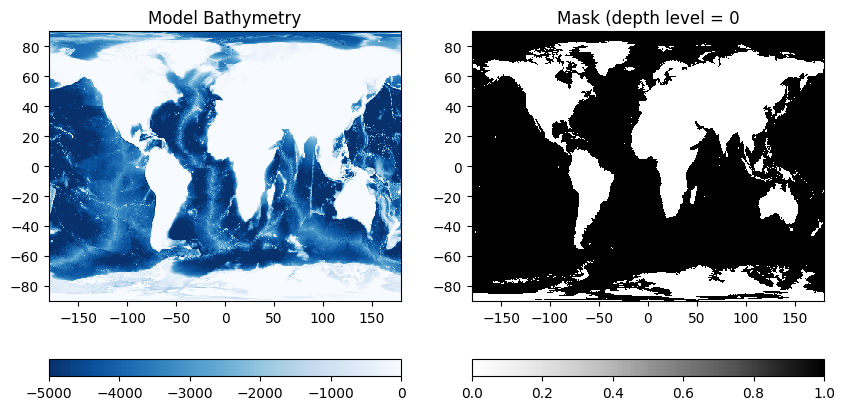

In [7]:
# Define the parameters that will be used in the data file.
DEL_X = 0.5
DEL_Y = 0.5
XG_ORIGIN = -180
YG_ORIGIN = -90
N_COLS = 720
N_ROWS = 360

# Recreate the grids that will be used in the model.
XC = np.arange(XG_ORIGIN + DEL_X / 2, XG_ORIGIN + N_COLS * DEL_X + DEL_X / 2, DEL_X)
YC = np.arange(YG_ORIGIN + DEL_Y / 2, YG_ORIGIN + N_ROWS * DEL_Y + DEL_Y / 2, DEL_Y)
XC_MG, YC_MG = np.meshgrid(XC, YC)

# read in the bathymetry file
BATHY_FILE = INPUT_DIR / "earth_bathymetry.bin"
BATHY = np.fromfile((str(BATHY_FILE)), ">f4").reshape(np.shape(XC_MG))
DEL_R = np.array(
    [
        10.00,
        10.00,
        10.00,
        10.00,
        10.00,
        10.00,
        10.00,
        10.01,
        10.03,
        10.11,
        10.32,
        10.80,
        11.76,
        13.42,
        16.04,
        19.82,
        24.85,
        31.10,
        38.42,
        46.50,
        55.00,
        63.50,
        71.58,
        78.90,
        85.15,
        90.18,
        93.96,
        96.58,
        98.25,
        99.25,
        100.01,
        101.33,
        104.56,
        111.33,
        122.83,
        139.09,
        158.94,
        180.83,
        203.55,
        226.50,
        249.50,
        272.50,
        295.50,
        318.50,
        341.50,
        364.50,
        387.50,
        410.50,
        433.50,
        456.50,
    ]
)
HFACC = hFac.create_hFacC_grid(BATHY, DEL_R)

# The mask is generated by setting all the non-zero hFac points to 1:
mask = np.copy(HFACC)
mask[mask > 0] = 1

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
C = plt.pcolormesh(XC_MG, YC_MG, BATHY, vmin=-5000, vmax=0, cmap="Blues_r")
plt.colorbar(C, orientation="horizontal")
plt.title("Model Bathymetry")

depth_level = 0
plt.subplot(1, 2, 2)
C = plt.pcolormesh(XC_MG, YC_MG, mask[0], vmin=0, vmax=1, cmap="Greys")
plt.colorbar(C, orientation="horizontal")
plt.title("Mask (depth level = " + str(depth_level))

plt.show()

## Step 4: Prepare the grids for interpolation

Since this is the modeling the entire planet, all 13 tiles are utilized.

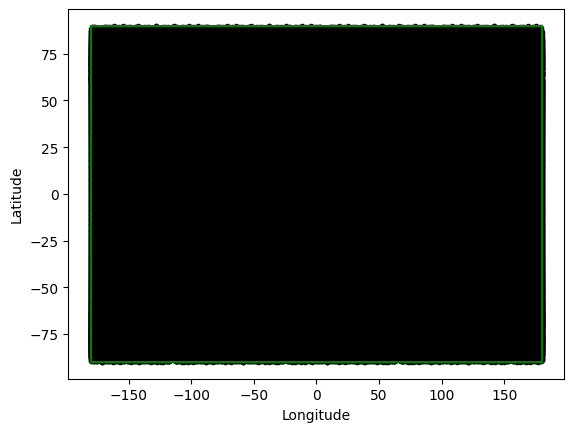

In [8]:
for i in range(1, 14):
    plt.plot(ECCO_XC_TILES[i], ECCO_YC_TILES[i], "k.")

# plot the boundary of the CA model
plt.plot(XC_MG[:, 0], YC_MG[:, 0], "g-")
plt.plot(XC_MG[:, -1], YC_MG[:, -1], "g-")
plt.plot(XC_MG[0, :], YC_MG[0, :], "g-")
plt.plot(XC_MG[-1, :], YC_MG[-1, :], "g-")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

The model boundary (green) is completely surrounded by the points in all tiles. All tiles will be used in interpolation:

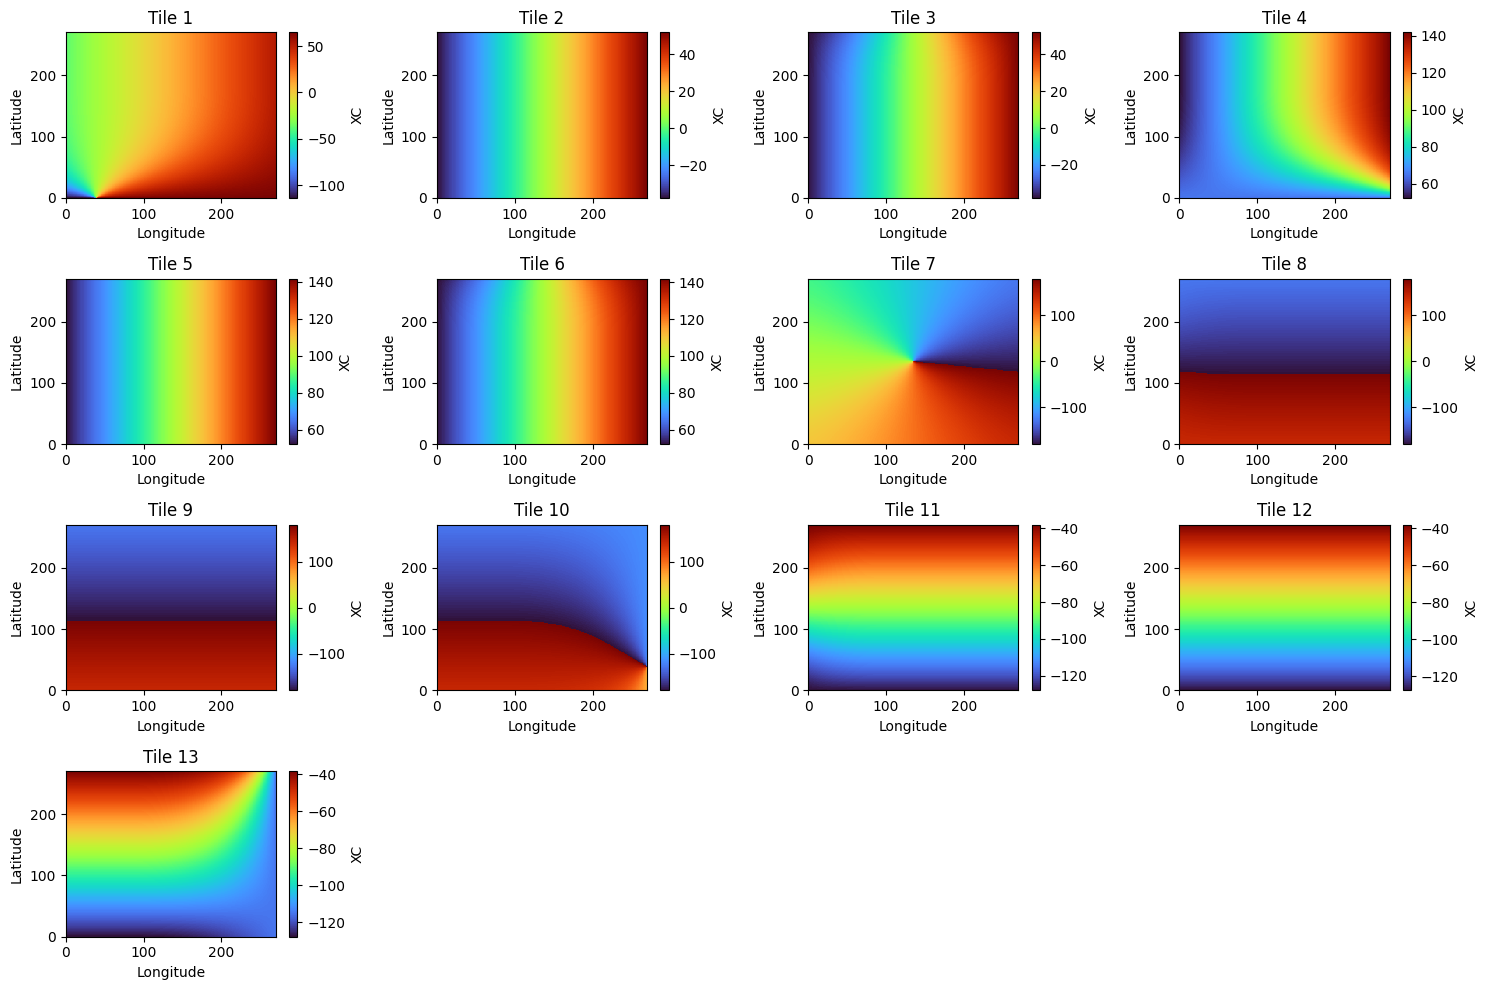

In [19]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10))
axes = axes.flatten()

for i in range(13):
    ax = axes[i]
    ax.set_title(f'Tile {i+1}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    C = ax.pcolormesh(ECCO_XC_TILES[i+1], cmap='turbo')
    fig.colorbar(C, ax=ax, orientation='vertical', label='XC')

for j in range(13, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Read in the real data fields and apply the modifications. First, create a dictionary to store the file names, then read the initial condition fields from the same tiles:

In [12]:
tile_list = list(range(1, 14))
# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ECCO_XC_TILES[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_hFacC_points = np.zeros((np.size(ECCO_RF_TILES[1]) , total_points))
ecco_hFacW_points = np.zeros((np.size(ECCO_RF_TILES[1]) , total_points))
ecco_hFacS_points = np.zeros((np.size(ECCO_RF_TILES[1]) , total_points))
ecco_mask_points = np.zeros((np.size(ECCO_RF_TILES[1]) , total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ECCO_XC_TILES[tile_number])

    ecco_XC_points[points_counted:points_counted+tile_N] = ECCO_XC_TILES[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ECCO_YC_TILES[tile_number].ravel()

    for k in range(np.size(ECCO_RF_TILES[tile_number])):
        level_hFacC = ECCO_HFACC_TILES[tile_number][k, :, :]
        level_hFacW = ECCO_HFACW_TILES[tile_number][k, :, :]
        level_hFacS = ECCO_HFACS_TILES[tile_number][k, :, :]
        level_mask = np.copy(level_hFacC)
        level_mask[level_mask>0] = 1
        ecco_hFacC_points[k, points_counted:points_counted+tile_N] = level_hFacC.ravel()
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        ecco_mask_points[k,points_counted:points_counted+tile_N] = level_mask.ravel()

        points_counted += tile_N

# make a file dictionary to loop over
FILE_PREFIX_DICT = {
    "ETAN": "ETAN_2009.nc",
    "THETA": "THETA_2009.nc",
    "SALT": "SALT_2009.nc",
    "UVEL": "UVELMASS_2009.nc",
    "VVEL": "VVELMASS_2009.nc",
}
VARIABLE_NAMES = list(FILE_PREFIX_DICT.keys())

# make a list to hold all of the ECCO grids
init_grids = []

# loop through each variable to read in the grid
for variable_name in VARIABLE_NAMES:
    if variable_name == "ETAN":
        ds = Dataset(DATA_DIR / FILE_PREFIX_DICT[variable_name])
        grid = ds.variables[variable_name][:, :, :, :]
        ds.close()
    elif "VEL" in variable_name:
        ds = Dataset(DATA_DIR / "UVELMASS_2009.nc")
        u_grid = ds.variables["UVELMASS"][:, :, :, :, :]
        ds.close()
        ds = Dataset(DATA_DIR / "VVELMASS_2009.nc")
        v_grid = ds.variables["VVELMASS"][:, :, :, :, :]
        ds.close()
    else:
        ds = Dataset(DATA_DIR / FILE_PREFIX_DICT[variable_name])
        grid = ds.variables[variable_name][:, :, :, :, :]
        ds.close()

    # create a grid of zeros to fill in
    N = np.shape(grid)[-1] * np.shape(grid)[-2]
    if variable_name == "ETAN":
        init_grid = np.zeros((1, N * 13))
    else:
        init_grid = np.zeros((np.size(ECCO_RF_TILES[1]), N * 13))

    # loop through the tiles
    points_counted = 0
    for tile_number in range(1, 14):
        if variable_name == "ETAN":
            init_grid[0, points_counted : points_counted + N] = grid[
                0, tile_number - 1, :, :
            ].ravel()
        elif (
            "VEL" in variable_name
        ):  # when using velocity, need to consider the tile rotations
            if variable_name == "UVEL":
                if tile_number < 7:
                    for k in range(np.size(ECCO_RF_TILES[1])):
                        init_grid[k, points_counted : points_counted + N] = u_grid[
                            0, k, tile_number - 1, :, :
                        ].ravel()
                else:
                    for k in range(np.size(ECCO_RF_TILES[1])):
                        init_grid[k, points_counted : points_counted + N] = v_grid[
                            0, k, tile_number - 1, :, :
                        ].ravel()
            if variable_name == "VVEL":
                if tile_number < 7:
                    for k in range(np.size(ECCO_RF_TILES[1])):
                        init_grid[k, points_counted : points_counted + N] = v_grid[
                            0, k, tile_number - 1, :, :
                        ].ravel()
                else:
                    for k in range(np.size(ECCO_RF_TILES[1])):
                        init_grid[k, points_counted : points_counted + N] = (
                            -1 * u_grid[0, k, tile_number - 1, :, :].ravel()
                        )
        else:
            for k in range(np.size(ECCO_RF_TILES[1])):
                init_grid[k, points_counted : points_counted + N] = grid[
                    0, k, tile_number - 1, :, :
                ].ravel()
        points_counted += N

    # apply some corrections
    if variable_name == "UVEL":
        for k in range(np.size(ECCO_RF_TILES[1])):
            non_zero_indices = ecco_hFacW_points[k, :] != 0
            init_grid[k, non_zero_indices] = (
                init_grid[k, non_zero_indices]
                / (ecco_hFacW_points[k, non_zero_indices])
            )
    if variable_name == "VVEL":
        for k in range(np.size(ECCO_RF_TILES[1])):
            non_zero_indices = ecco_hFacS_points[k, :] != 0
            init_grid[k, non_zero_indices] = (
                init_grid[k, non_zero_indices]
                / (ecco_hFacS_points[k, non_zero_indices])
            )

    init_grids.append(init_grid)

## Step 5: Interpolate the Fields onto the Model Grid

ECCO external fields are interpolate to the model domain. The `horizonal` modfule from the `eccoseas` package is used to interpolate the fields.

In [14]:
# --- Pre-compute Source Coordinates ---
# We do this once to save overhead
ECCO_POINTS_STACKED = np.column_stack([ecco_XC_points, ecco_YC_points])

print("Starting 3D Interpolation (Sequential Mode to prevent OOM)...")

for variable_name, init_grid in zip(tqdm(VARIABLE_NAMES), init_grids):
    print(f"\nProcessing {variable_name}...")

    # 1. Determine Masking based on variable type
    if variable_name == "ETAN":
        model_mask_target = mask[:1, :, :] # Surface only
    else:
        model_mask_target = mask

    # 2. Get dimensions
    n_layers = init_grid.shape[0]

    # Pre-allocate the output array in memory
    # This reserves the exact RAM needed upfront
    interpolated_grid = np.zeros((n_layers, XC_MG.shape[0], XC_MG.shape[1]), dtype='>f4')

    # 3. SEQUENTIAL LOOP (The Fix)
    # We process one layer at a time to keep RAM usage low.
    for k in tqdm(range(n_layers), desc=f"Layers ({variable_name})", leave=False):

        # Interpolate a single 2D depth slice
        # This function creates temporary matrices, but they are freed
        # immediately after this line, keeping memory usage stable.
        interpolated_slice = horizontal.downscale_2D_points_with_zeros(
            ECCO_POINTS_STACKED,
            init_grid[k].ravel(),
            ecco_mask_points[k],
            XC_MG,
            YC_MG,
            model_mask_target[k]
        )

        # Store result directly into the pre-allocated array
        interpolated_grid[k, :, :] = interpolated_slice

    # 4. Save to Disk
    output_file = INPUT_DIR / f"{variable_name}_IC.bin"
    print(f"Saving to {output_file}...")
    interpolated_grid.ravel("C").astype(">f4").tofile(str(output_file))

    # Explicitly delete the large array to free RAM for the next variable
    del interpolated_grid

print("All Initial Conditions processed successfully.")

Starting 3D Interpolation (Sequential Mode to prevent OOM)...


  0%|          | 0/5 [00:00<?, ?it/s]


Processing ETAN...



 20%|██        | 1/5 [00:19<01:18, 19.73s/it]               

Saving to /home/jon/src/sjsu/cs185c-fall2024/project/input/ETAN_IC.bin...

Processing THETA...



 40%|████      | 2/5 [06:55<12:03, 241.09s/it]                 

Saving to /home/jon/src/sjsu/cs185c-fall2024/project/input/THETA_IC.bin...

Processing SALT...



 60%|██████    | 3/5 [13:29<10:21, 310.67s/it]                

Saving to /home/jon/src/sjsu/cs185c-fall2024/project/input/SALT_IC.bin...

Processing UVEL...



 80%|████████  | 4/5 [19:55<05:40, 340.43s/it]                

Saving to /home/jon/src/sjsu/cs185c-fall2024/project/input/UVEL_IC.bin...

Processing VVEL...



100%|██████████| 5/5 [26:21<00:00, 316.39s/it]                

Saving to /home/jon/src/sjsu/cs185c-fall2024/project/input/VVEL_IC.bin...
All Initial Conditions processed successfully.


## Step 6: Plotting the External Forcing Fields

With fields generated, they are plotted to ensure everything is as expected. Metadata is generated for each one:

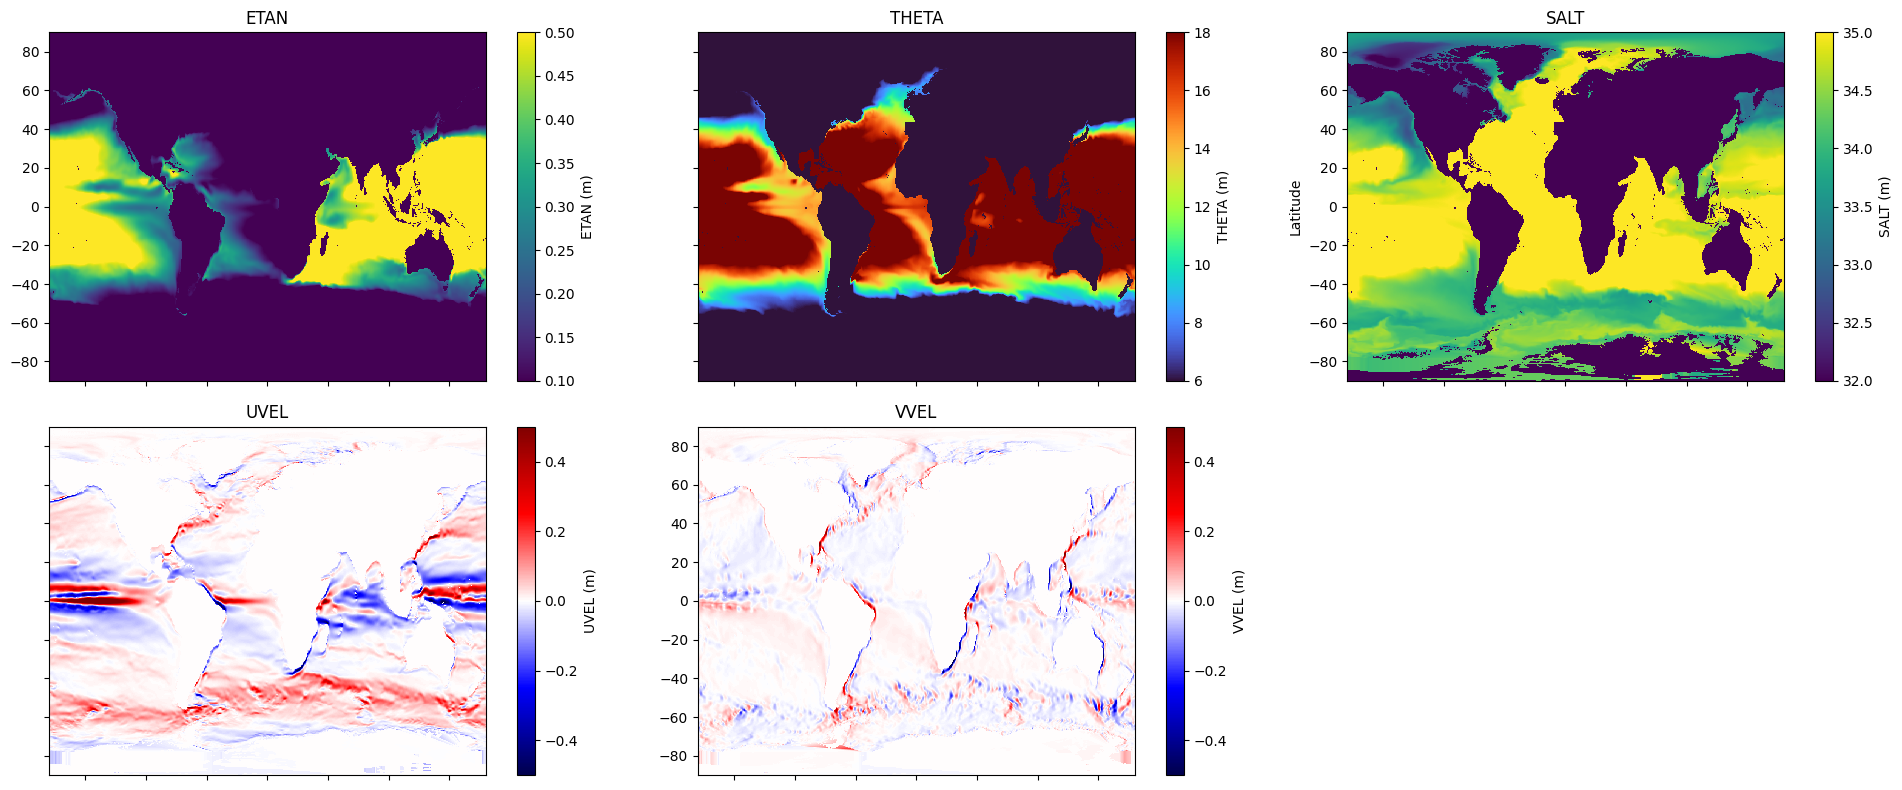

In [16]:
meta_dict = {
    "ETAN": [0.1, 0.5, "viridis", "m"],
    "THETA": [6, 18, "turbo", "m"],
    "SALT": [32, 35, "viridis", "m"],
    "UVEL": [-0.5, 0.5, "seismic", "m"],
    "VVEL": [-0.5, 0.5, "seismic", "m"],
}

fig = plt.figure(figsize=(20, 8))

for i in range(len(VARIABLE_NAMES)):
    variable_name = VARIABLE_NAMES[i]

    global_init_grid = np.fromfile(str(INPUT_DIR / variable_name) + "_IC.bin", ">f4")

    if variable_name == "ETAN":
        global_init_grid = global_init_grid.reshape(
            (np.shape(XC_MG)[0], np.shape(XC_MG)[1])
        )
    else:
        global_init_grid = global_init_grid.reshape(
            (np.shape(DEL_R)[0], np.shape(XC_MG)[0], np.shape(XC_MG)[1])
        )
        global_init_grid = global_init_grid[
            10, :, :
        ]  # choose just the surface for plotting

    plt.subplot(2, 3, i + 1)
    C = plt.pcolormesh(
        XC_MG,
        YC_MG,
        global_init_grid,
        vmin=meta_dict[VARIABLE_NAMES[i]][0],
        vmax=meta_dict[VARIABLE_NAMES[i]][1],
        cmap=meta_dict[VARIABLE_NAMES[i]][2],
    )
    plt.colorbar(
        C,
        label=VARIABLE_NAMES[i] + " (" + meta_dict[VARIABLE_NAMES[i]][3] + ")",
        fraction=0.26,
    )

    if i < 5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel("Longitude")
    if i % 2 == 1:
        plt.gca().set_yticklabels([])
    if i == 7:
        plt.gca().axis("off")
    if i == 2:
        plt.gca().set_ylabel("Latitude")
    plt.title(variable_name)

plt.tight_layout()

plt.show()

## Step 7: Run-time considerations

To use the grids as initial conditions in the model,
I will specify them as "hydrography" conditions.
Specifically,
I will add the following lines to `PARM05` of the data file:

```
hydrogThetaFile = 'THETA_IC.bin',
hydrogSaltFile = 'SALT_IC.bin',
uVelInitFile = 'UVEL_IC.bin',
vVelInitFile = 'VVEL_IC.bin',
pSurfInitFile = 'ETAN_IC.bin',
```